In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
for_hire_vehicle_data = pd.read_csv('/Users/disastershubz/Documents/PROJECT/For-Hire Vehicle Trip Records .csv')
green_taxi_data = pd.read_csv('/Users/disastershubz/Documents/PROJECT/green_taxi_data.csv')
citibike_data = pd.read_csv('/Users/disastershubz/Documents/PROJECT/citibike_data.csv')
yellow_taxi_data = pd.read_csv('/Users/disastershubz/Documents/PROJECT/yellow_taxi_data.csv')

In [5]:
taxi_zones = pd.read_csv('/Users/disastershubz/Documents/PROJECT/taxi_zones.csv')

In [6]:
citibike_stations = pd.read_csv('/Users/disastershubz/Documents/PROJECT/citibike_stations.csv')

    * Environmental Agencies: Track environmental impact by promoting bike usage over taxis in high-congestion areas.


In [8]:
import pandas as pd
import numpy as np

# CO2 emission factor (e.g., kg CO2 per taxi trip for simplicity)
CO2_emission_per_taxi_trip = 0.5  # Assume 0.5 kg of CO2 per taxi trip

# 1. Identify high-congestion taxi zones by total trip count
yellow_taxi_pickups = yellow_taxi_data.groupby('PULocationID').size().reset_index(name='yellow_trip_count')
green_taxi_pickups = green_taxi_data.groupby('PULocationID').size().reset_index(name='green_trip_count')

# Merge yellow and green taxi pickups to get total trip counts by location
total_taxi_trips = pd.merge(
    yellow_taxi_pickups, green_taxi_pickups, on='PULocationID', how='outer'
).fillna(0)

# Calculate total trip count by summing yellow and green trips
total_taxi_trips['total_trip_count'] = total_taxi_trips['yellow_trip_count'] + total_taxi_trips['green_trip_count']

# Filter for high-congestion zones
high_congestion_zones = total_taxi_trips[total_taxi_trips['total_trip_count'] > 500]

# Map zone information by merging with taxi_zones data on LocationID
high_congestion_zones = high_congestion_zones.merge(
    taxi_zones[['LocationID', 'zone', 'borough']],
    left_on='PULocationID', right_on='LocationID', how='left'
)

# 2. Estimate potential CO2 emissions based on high taxi usage
high_congestion_zones['estimated_CO2_emission'] = high_congestion_zones['total_trip_count'] * CO2_emission_per_taxi_trip

# 3. Summarize by zone to recommend focus areas for environmental improvement
# Sum up the CitiBike station capacities near each high-congestion taxi zone
citibike_capacity_summary = citibike_stations.groupby('region_id').agg({'capacity': 'sum'}).reset_index()

# Convert `borough` and `region_id` to strings for consistent merging
high_congestion_zones['borough'] = high_congestion_zones['borough'].astype(str)
citibike_capacity_summary['region_id'] = citibike_capacity_summary['region_id'].astype(str)

# Join the congestion data with nearby CitiBike capacities, matching by region or borough
congestion_bike_recommendations = high_congestion_zones.merge(
    citibike_capacity_summary, left_on='borough', right_on='region_id', how='left'
).fillna(0)

# Sort to prioritize high-impact areas
congestion_bike_recommendations = congestion_bike_recommendations.sort_values(by='total_trip_count', ascending=False)

# Display the high-congestion zones with recommended CitiBike station capacities
print("High-Congestion Zones with Nearby CitiBike Station Capacity:")
print(congestion_bike_recommendations[['zone', 'borough', 'total_trip_count', 'estimated_CO2_emission', 'capacity']])


High-Congestion Zones with Nearby CitiBike Station Capacity:
                            zone    borough  total_trip_count  \
49                   JFK Airport     Queens          177077.0   
64                Midtown Center  Manhattan          142023.0   
92         Upper East Side South  Manhattan          120256.0   
65                  Midtown East  Manhattan          105872.0   
72  Penn Station/Madison Sq West  Manhattan          101484.0   
..                           ...        ...               ...   
75                 Richmond Hill     Queens             521.0   
78                 South Jamaica     Queens             519.0   
70                   Old Astoria     Queens             515.0   
16                  Clinton Hill   Brooklyn             507.0   
80     Springfield Gardens South     Queens             501.0   

    estimated_CO2_emission  capacity  
49                 88538.5       0.0  
64                 71011.5       0.0  
92                 60128.0       0.0  
65

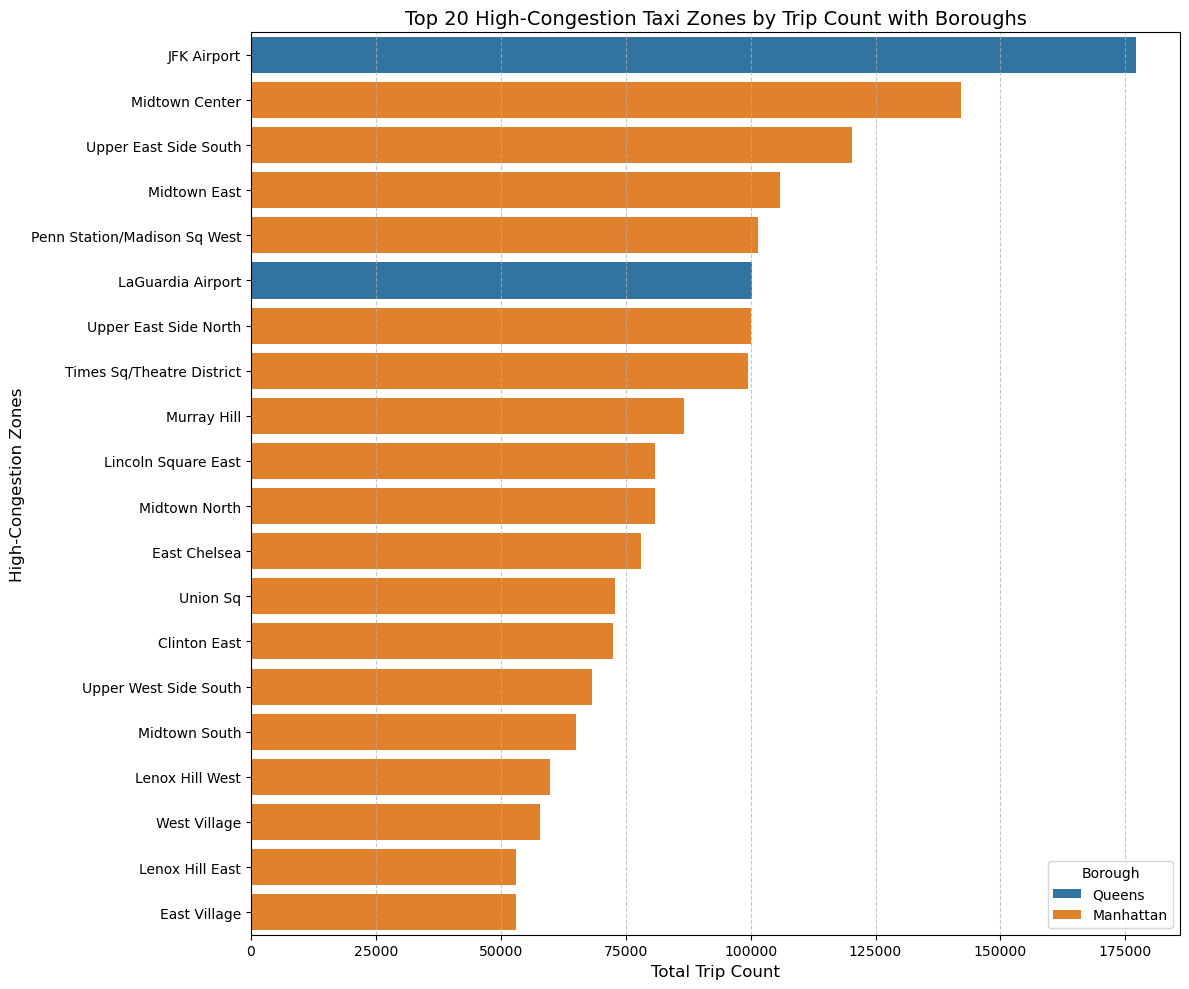

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 20 zones with highest congestion
top_zones = congestion_bike_recommendations.sort_values(by='total_trip_count', ascending=False).head(20)

# Create a bar chart for high-congestion zones sorted by total trip count
plt.figure(figsize=(12, 10))
sns.barplot(
    x='total_trip_count', 
    y='zone', 
    data=top_zones,
    hue='borough', 
    dodge=False
)

# Improve the readability of the chart
plt.xlabel('Total Trip Count', fontsize=12)
plt.ylabel('High-Congestion Zones', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Top 20 High-Congestion Taxi Zones by Trip Count with Boroughs', fontsize=14)

# Adjust legend
plt.legend(title='Borough', loc='lower right', fontsize=10)

# Add gridlines for easier reading of trip counts
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [10]:
taxi_zones.head

<bound method NDFrame.head of      OBJECTID  Shape_Leng                                           the_geom  \
0           1    0.116357  MULTIPOLYGON (((-74.18445299999996 40.69499599...   
1           2    0.433470  MULTIPOLYGON (((-73.82337597260663 40.63898704...   
2           3    0.084341  MULTIPOLYGON (((-73.84792614099985 40.87134223...   
3           4    0.043567  MULTIPOLYGON (((-73.97177410965318 40.72582128...   
4           5    0.092146  MULTIPOLYGON (((-74.17421738099989 40.56256808...   
..        ...         ...                                                ...   
258       256    0.067915  MULTIPOLYGON (((-73.95834207500002 40.71330630...   
259       259    0.126750  MULTIPOLYGON (((-73.85107116191898 40.91037152...   
260       260    0.133514  MULTIPOLYGON (((-73.90175373399988 40.76077547...   
261       261    0.027120  MULTIPOLYGON (((-74.01332610899988 40.70503078...   
262       262    0.049064  MULTIPOLYGON (((-73.94383256699986 40.78285908...   

     Shap

In [11]:
import geopandas as gpd
from shapely import wkt

# Convert `taxi_zones` DataFrame to a GeoDataFrame using the 'the_geom' column
taxi_zones['geometry'] = taxi_zones['the_geom'].apply(wkt.loads)  # Convert WKT to geometry
taxi_zones_gdf = gpd.GeoDataFrame(taxi_zones, geometry='geometry')

# Calculate the centroid for each zone
taxi_zones_gdf['centroid'] = taxi_zones_gdf['geometry'].centroid
taxi_zones_gdf['latitude'] = taxi_zones_gdf['centroid'].y
taxi_zones_gdf['longitude'] = taxi_zones_gdf['centroid'].x


In [12]:
congestion_bike_recommendations = congestion_bike_recommendations.merge(
    taxi_zones_gdf[['LocationID', 'latitude', 'longitude']], 
    left_on='PULocationID', 
    right_on='LocationID', 
    how='left'
)


In [13]:
import folium
from folium.plugins import MarkerCluster

# Filter out rows with missing latitude or longitude
valid_data = congestion_bike_recommendations.dropna(subset=['latitude', 'longitude'])

# Initialize the map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Plot high-congestion zones on the map
for _, row in valid_data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5 + (row['total_trip_count'] / 50000),  # Size by total trip count
        color='blue' if row['capacity'] > 0 else 'red',  # Highlight zones with zero CitiBike capacity in red
        fill=True,
        fill_color='blue' if row['capacity'] > 0 else 'red',
        fill_opacity=0.6,
        tooltip=(f"Zone: {row['zone']}<br>Borough: {row['borough']}<br>"
                 f"Total Trips: {row['total_trip_count']}<br>"
                 f"Estimated CO₂ Emission: {row['estimated_CO2_emission']} kg<br>"
                 f"CitiBike Capacity: {row['capacity']}")
    ).add_to(nyc_map)

# Display the map
nyc_map


In [15]:
nyc_map.save("/Users/disastershubz/Documents/PROJECT/nyc_map_4.html")